In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

## Importing Data and DateTime index preparation

In [4]:
df = pd.read_csv("data/bicikelj_train.csv")
# Convert the "timespamp" colum to a datetime object and set it as the index
df = df.set_index("timestamp")
df.index = pd.to_datetime(df.index)

# Count the number of duplicate index values
display(df.index.duplicated().sum())

display(df.head())
display(df.info())

0

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,POGAČARJEV TRG-TRŽNICA,KONGRESNI TRG-ŠUBIČEVA ULICA,CANKARJEVA UL.-NAMA,BREG,GRUDNOVO NABREŽJE-KARLOVŠKA C.,MIKLOŠIČEV PARK,BAVARSKI DVOR,TRG OF-KOLODVORSKA UL.,MASARYKOVA DDC,...,POVŠETOVA - KAJUHOVA,SOSESKA NOVO BRDO,TEHNOLOŠKI PARK,VOJKOVA - GASILSKA BRIGADA,GERBIČEVA - ŠPORTNI PARK SVOBODA,DOLENJSKA C. - STRELIŠČE,ROŠKA - STRELIŠKA,LEK - VEROVŠKOVA,VOKA - SLOVENČEVA,SUPERNOVA LJUBLJANA - RUDNIK
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-02 13:04:00,17,17,20,26,10,10,16,7,12,2,...,9,7,5,4,2,9,4,8,3,1
2022-08-02 13:10:00,18,17,19,25,10,11,15,7,12,4,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:14:00,17,18,19,25,9,11,16,7,12,5,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:20:00,18,15,20,26,12,11,18,6,13,1,...,9,7,5,2,1,9,4,8,2,1
2022-08-02 13:25:00,20,16,19,23,12,10,17,6,15,1,...,9,7,5,2,1,9,4,8,2,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7739 entries, 2022-08-02 13:04:00 to 2022-10-01 18:23:00
Data columns (total 83 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    7739 non-null   int64
 1   POGAČARJEV TRG-TRŽNICA                7739 non-null   int64
 2   KONGRESNI TRG-ŠUBIČEVA ULICA          7739 non-null   int64
 3   CANKARJEVA UL.-NAMA                   7739 non-null   int64
 4   BREG                                  7739 non-null   int64
 5   GRUDNOVO NABREŽJE-KARLOVŠKA C.        7739 non-null   int64
 6   MIKLOŠIČEV PARK                       7739 non-null   int64
 7   BAVARSKI DVOR                         7739 non-null   int64
 8   TRG OF-KOLODVORSKA UL.                7739 non-null   int64
 9   MASARYKOVA DDC                        7739 non-null   int64
 10  VILHARJEVA CESTA                      7739 non-null   int64
 11  PARK NA

None

## Creating a DataFrame for each station

In [5]:
# Split the dataframe into multiple dataframes, each with one station
df_list = [df[[station]] for station in df.columns]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE
timestamp,
2022-08-02 13:04:00,17
2022-08-02 13:10:00,18
2022-08-02 13:14:00,17
2022-08-02 13:20:00,18
2022-08-02 13:25:00,20


### Data distribution of one station

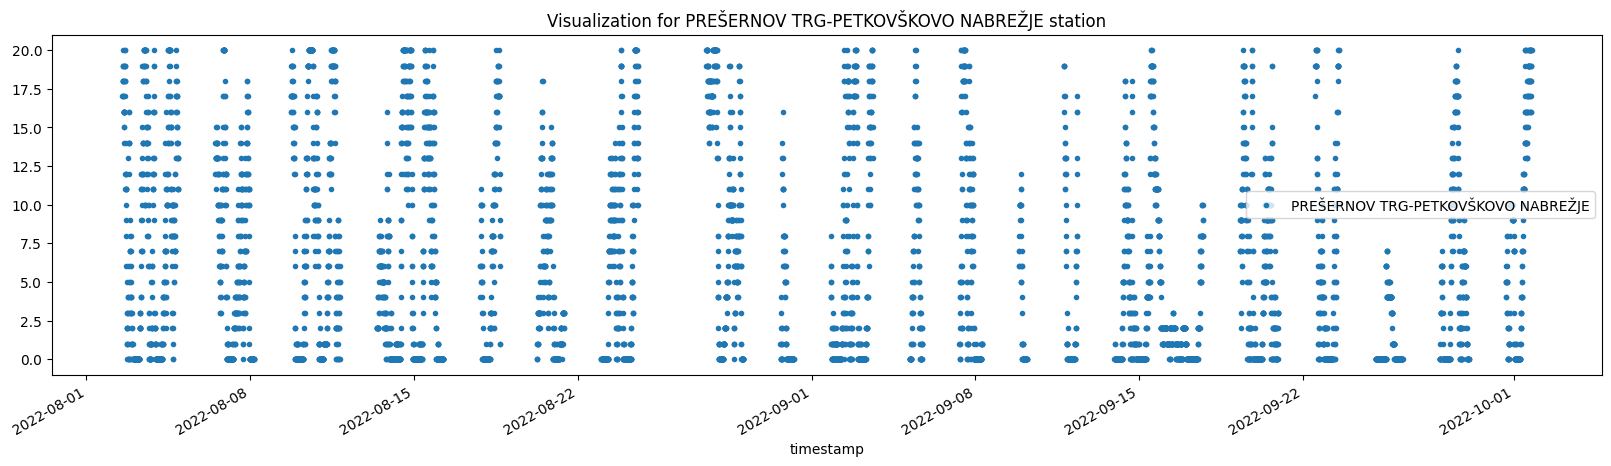

In [6]:
ig, ax = plt.subplots(figsize=(20, 5))
df_list[0].plot(ax=ax, label='Training Set', title=f"Visualization for {df_list[0].columns[0]} station", style=".")
plt.show()

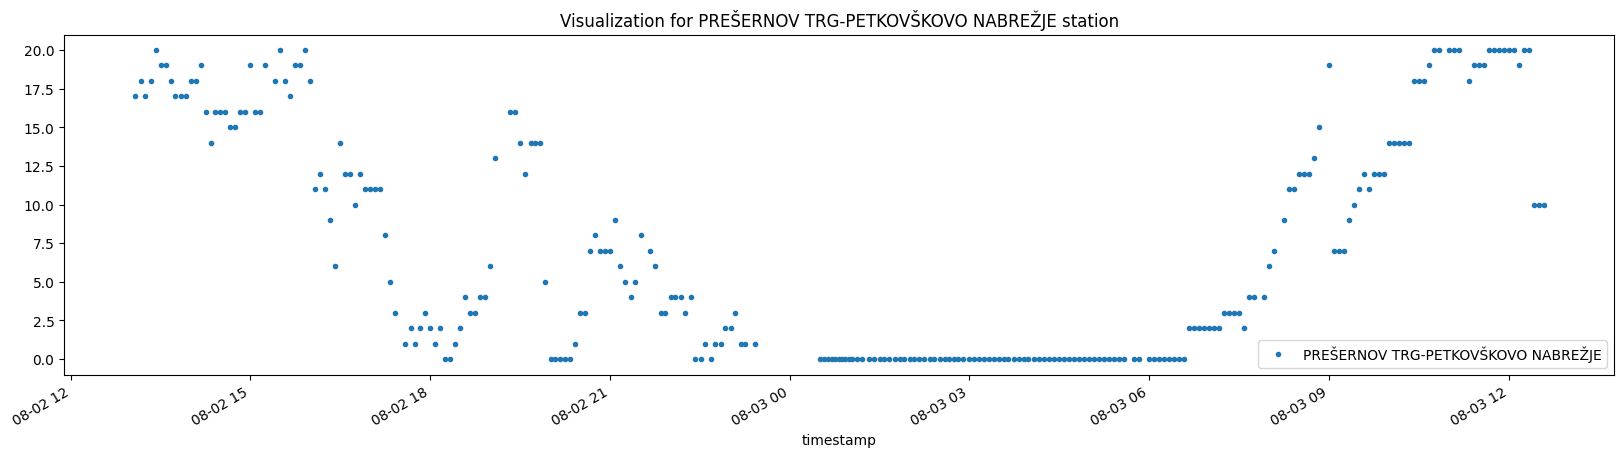

In [7]:
ig, ax = plt.subplots(figsize=(20, 5))
df_list[0][:260].plot(ax=ax, label='Training Set', title=f"Visualization for {df_list[0][:260].columns[0]} station", style=".")
plt.show()

## Time Series Cross Validation Example and Visualization

In [8]:
tss = TimeSeriesSplit(n_splits=5, gap=(60 // 5))
df_list = [station.sort_index() for station in df_list]

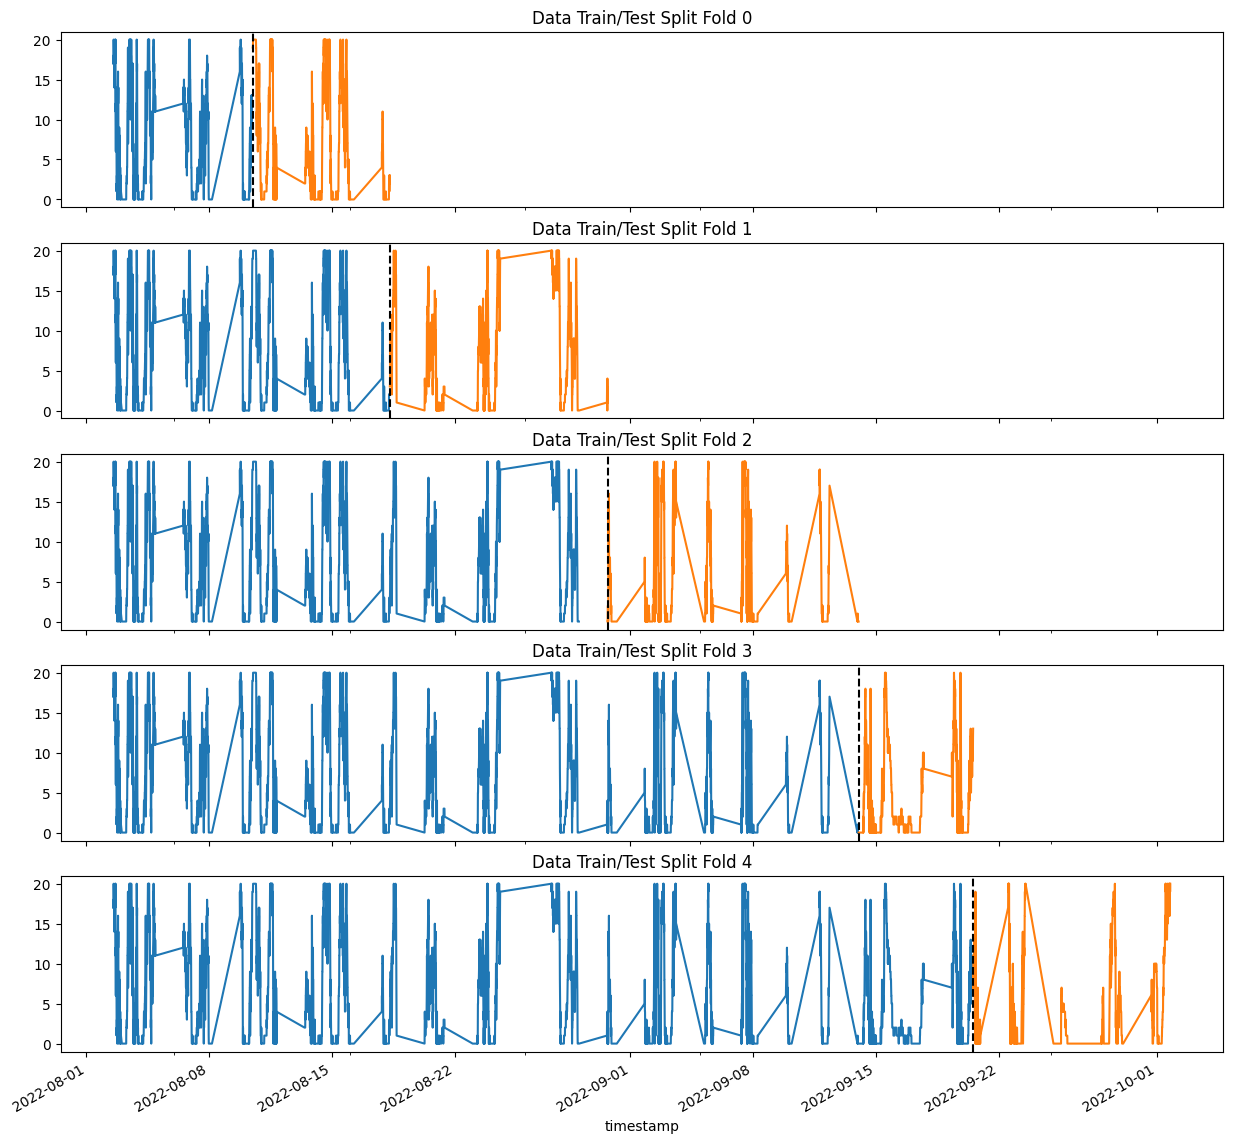

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_list[0]):
    train = df_list[0].iloc[train_idx]
    test = df_list[0].iloc[val_idx]
    train[df_list[0].columns[0]].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test[df_list[0].columns[0]].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Feature creation

## Features created from datetime index (hour, dayofweek, month, dayofyear, dayofmonth)

In [10]:
def create_features(station):
    """
    Create time series features based on time series index.
    """
    station = station.copy()
    station['hour'] = station.index.hour
    station['dayofweek'] = station.index.dayofweek
    station['month'] = station.index.month
    station['dayofyear'] = station.index.dayofyear
    station['dayofmonth'] = station.index.day
    return station

df_list = [create_features(station) for station in df_list]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth
timestamp,,,,,,
2022-08-02 13:04:00,17,13,1,8,214,2
2022-08-02 13:10:00,18,13,1,8,214,2
2022-08-02 13:14:00,17,13,1,8,214,2
2022-08-02 13:20:00,18,13,1,8,214,2
2022-08-02 13:25:00,20,13,1,8,214,2


<Axes: xlabel='hour', ylabel='PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE'>

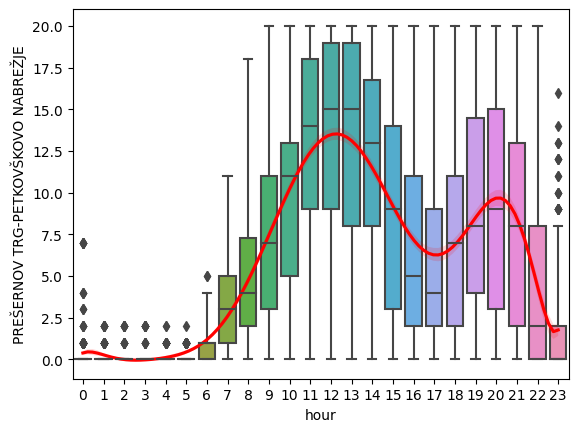

In [11]:
# Plot a boxplot of the relationship between the hour and the target for the first station
sns.boxplot(x='hour', y=df_list[0].columns[0], data=df_list[0], whis=3)
sns.regplot(x='hour', y=df_list[0].columns[0], data=df_list[0], scatter=False, order=10, label='order 10', color='red')

<Axes: xlabel='hour', ylabel='PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE'>

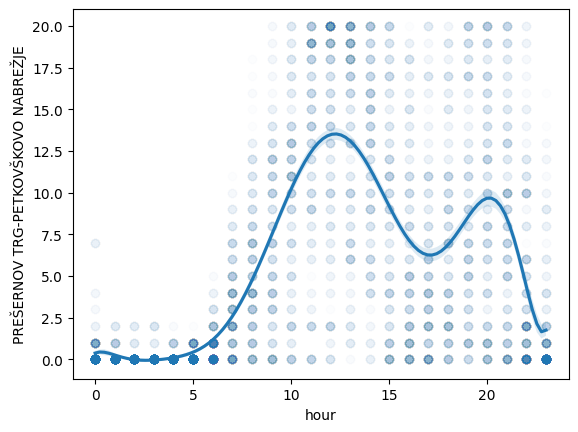

In [12]:
# Plot the a scatterplot of relationship between the hour and the target for the first station
plt.scatter(df_list[0]['hour'], df_list[0][df_list[0].columns[0]], alpha=0.01)
# Plot a polynomial regression line of order 2 between the hour and the target for the first station
sns.regplot(x='hour', y=df_list[0].columns[0], data=df_list[0], scatter=False, order=10, label='order 10')

# Polynomial Features

In [13]:
# Add a polynomial feature of order (and all the lower polinomials) 10 for the "hour" to the dataframe
# First fit the standard scaler to the "hour" column
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_list[0][['hour']])
def add_poly_features(station, column, degree, scaler=scaler):
    # Scale the hour column
    station[column] = scaler.transform(station[[column]])
    for i in range(2, degree+1):
        station[f"{column}^{i}"] = (station[column]**i)
    # Unscale the hour column
    station[column] = scaler.inverse_transform(station[[column]])
    return station

df_list = [add_poly_features(station, 'hour', 10) for station in df_list]

In [14]:
display(df_list[0].tail())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,hour^6,hour^7,hour^8,hour^9,hour^10
timestamp,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,0.474408,0.436685
2022-10-01 18:07:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,0.474408,0.436685
2022-10-01 18:13:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,0.474408,0.436685
2022-10-01 18:16:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,0.474408,0.436685
2022-10-01 18:23:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,0.474408,0.436685


# Product features

In [15]:
# Add the product of the "hour" and the "dayofweek" as a feature to the dataframe
def add_product_feature(station, column1, column2):
    station[f"{column1}*{column2}"] = station[column1]*station[column2]
    return station

# Add the product of all the features that contain the string "hour" and the feature "dayofweek" as a feature to the dataframe
def add_product_features(station, column):
    for col in station.columns:
        if 'hour' in col:
            station = add_product_feature(station, col, column)
    return station

df_list = [add_product_features(station, 'dayofweek') for station in df_list]

## Lag features (60 and 120 min lag)

In [16]:
def add_lags(station):
    station = station.copy()
    # Create 60, 90 and 120 minutes lags
    # lags = [60, 90, 120]
    lags = [60, 120]
    for lag in lags:
        df_lag = station.copy()
        # Drop all but the target column
        df_lag = df_lag[[station.columns[0]]]
        # Subtract 60 minutes from the index
        df_lag.index = df_lag.index + pd.Timedelta(minutes=lag)
        # Rename the column to "lag_60"
        df_lag.columns = [f"lag_{lag}"]
        # Merge the dataframe with the lagged dataframe
        station = pd.merge_asof(
            station,
            df_lag,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta("15m"),
        )
    return station

df_list = [add_lags(station) for station in df_list]
display(df_list[0].tail())
display(df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,...,hour^3*dayofweek,hour^4*dayofweek,hour^5*dayofweek,hour^6*dayofweek,hour^7*dayofweek,hour^8*dayofweek,hour^9*dayofweek,hour^10*dayofweek,lag_60,lag_120
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.899605,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,19.0
2022-10-01 18:07:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.899605,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,19.0
2022-10-01 18:13:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.899605,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0
2022-10-01 18:16:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.899605,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0
2022-10-01 18:23:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.899605,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE      0
hour                                    0
dayofweek                               0
month                                   0
dayofyear                               0
dayofmonth                              0
hour^2                                  0
hour^3                                  0
hour^4                                  0
hour^5                                  0
hour^6                                  0
hour^7                                  0
hour^8                                  0
hour^9                                  0
hour^10                                 0
hour*dayofweek                          0
hour^2*dayofweek                        0
hour^3*dayofweek                        0
hour^4*dayofweek                        0
hour^5*dayofweek                        0
hour^6*dayofweek                        0
hour^7*dayofweek                        0
hour^8*dayofweek                        0
hour^9*dayofweek                  

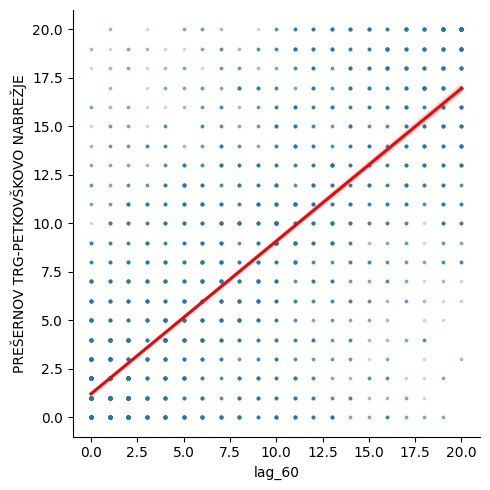

In [17]:
# Plot a regression plot to see the relationship between the target and the lagged features for the first station
sns.lmplot(
    x="lag_60",
    y=df_list[0].columns[0],
    data=df_list[0],
    scatter_kws={"s": 3, "alpha": 0.2},
    line_kws={"color": "red"},
)
plt.show()

## School day feature (0 for holidays and weekends, 1 for school days)

In [18]:
def add_school_days(station):
    # Add vacation feature which is 1 if the day is a school vacation day and 0 otherwise
    # School days are from 1.9.2022 to 31.10.2022 without weekends
    station["vacation"] = 0
    station.loc[(station.index >= "2022-09-01") & (station.index <= "2022-10-31") & (station.index.dayofweek < 5), "vacation"] = 1
    return station

df_list = [add_school_days(station) for station in df_list]
display(df_list[0].tail())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,...,hour^4*dayofweek,hour^5*dayofweek,hour^6*dayofweek,hour^7*dayofweek,hour^8*dayofweek,hour^9*dayofweek,hour^10*dayofweek,lag_60,lag_120,vacation
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,19.0,0
2022-10-01 18:07:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,19.0,0
2022-10-01 18:13:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0
2022-10-01 18:16:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0
2022-10-01 18:23:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.589529,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0


## Weather feature (Amount of rain in mm)

In [19]:
weather = pd.read_csv("data/extra/padavine_polurno.csv")
weather = weather.drop(columns=["station_id", "station_name"])
weather["datum"] = pd.to_datetime(weather["datum"])
weather = weather.set_index("datum")
weather.info()

def add_weather(df, weather):
    df = df.copy()
    weather = weather.copy()
    # Add weather features by matrhing the Date, Hour of the day and the station
    return pd.merge_asof(
        df,
        weather,
        left_index=True,
        right_index=True,
        direction="nearest",
    )

df_list = [add_weather(station, weather) for station in df_list]
display(df_list[0].tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2022-08-01 00:00:00 to 2022-10-01 23:30:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   padavine  2976 non-null   float64
dtypes: float64(1)
memory usage: 46.5 KB


,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,...,hour^5*dayofweek,hour^6*dayofweek,hour^7*dayofweek,hour^8*dayofweek,hour^9*dayofweek,hour^10*dayofweek,lag_60,lag_120,vacation,padavine
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,19.0,0,0.0
2022-10-01 18:07:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,19.0,0,0.0
2022-10-01 18:13:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0,0.0
2022-10-01 18:16:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0,0.0
2022-10-01 18:23:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,3.304109,3.041384,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0,0.0


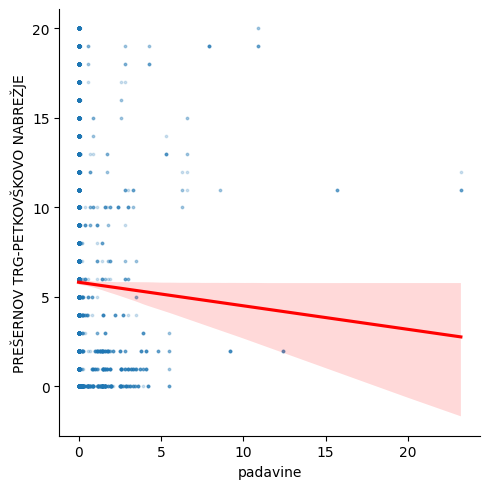

In [20]:
# Plot a regression plot to see the relationship between the target and the padavine feature for the first station
sns.lmplot(
    x="padavine",
    y=df_list[0].columns[0],
    data=df_list[0],
    scatter_kws={"s": 3, "alpha": 0.2},
    line_kws={"color": "red"},
)
plt.show()

# Free spaces feature

In [21]:
metadata = pd.read_csv("data/extra/bicikelj_metadata.csv")

def free_spaces(station):
    station = station.copy()
    # Get the total number of spaces for the station
    station_metadata = metadata[metadata["postaja"] == station.columns[0]]
    total_space = station_metadata["total_space"].values[0]
    lags = [60, 120]
    for lag in lags:
        station_lag = station.copy()
        # Drop all but the target column
        station_lag = station_lag[[station.columns[0]]]
        # Subtract the number of occupied spaces from the total number of spaces
        station_lag[station.columns[0]] = total_space - station_lag[station.columns[0]]
        # Subtract 60 minutes from the index
        station_lag.index = station_lag.index + pd.Timedelta(minutes=lag)
        # Rename the column to "lag_60"
        station_lag.columns = [f"free_space_lag_{lag}"]
        # Merge the dataframe with the lagged dataframe
        station = pd.merge_asof(
            station,
            station_lag,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta("15m"),
        )
    return station

df_list = [free_spaces(station) for station in df_list]
display(df_list[0].tail())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,...,hour^7*dayofweek,hour^8*dayofweek,hour^9*dayofweek,hour^10*dayofweek,lag_60,lag_120,vacation,padavine,free_space_lag_60,free_space_lag_120
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,2.799549,2.576944,2.372039,2.183427,20.0,19.0,0,0.0,0.0,1.0
2022-10-01 18:07:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,2.799549,2.576944,2.372039,2.183427,20.0,19.0,0,0.0,0.0,1.0
2022-10-01 18:13:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0,0.0,0.0,2.0
2022-10-01 18:16:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0,0.0,0.0,2.0
2022-10-01 18:23:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,2.799549,2.576944,2.372039,2.183427,20.0,18.0,0,0.0,0.0,2.0


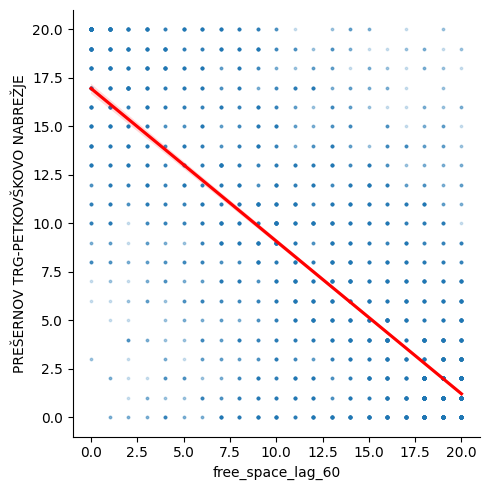

In [22]:
# Plot a regression plot to see the relationship between the target and the free_space_lag_60 feature for the first station
sns.lmplot(
    x="free_space_lag_60",
    y=df_list[0].columns[0],
    data=df_list[0],
    scatter_kws={"s": 3, "alpha": 0.2},
    line_kws={"color": "red"},
)
plt.show()

# Closest stations feature

In [23]:
def add_closest_station_lags(station1, station2, index):
    station1 = station1.copy()
    station2 = station2.copy()
    # Create 60, 90 and 120 minutes lags
    # lags = [60, 90, 120]
    lags = [60, 120]
    for lag in lags:
        station2_lag = station2.copy()
        # Drop all but the target column
        station2_lag = station2_lag[[station2.columns[0]]]
        # Subtract 60 minutes from the index
        station2_lag.index = station2_lag.index + pd.Timedelta(minutes=lag)
        # Rename the column to "lag_60"
        station2_lag.columns = [f"station_{index}_lag_{lag}"]
        # Merge the dataframe with the lagged dataframe
        station1 = pd.merge_asof(
            station1,
            station2_lag,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta("15m"),
        )
    return station1





number_of_closest_stations = 5
def add_n_closest(station, df, metadata, n=5):
    station = station.copy()
    metadata = metadata.copy()
    metadata = metadata.copy()
    # Get the row where the "postaja" column matches the station name
    station_metadata = metadata[metadata["postaja"] == station.columns[0]]
    longitude, latitude = station_metadata["geo-visina"].values[0], station_metadata["geo-sirina"].values[0]

    # Add the distance from the station to every other station
    metadata["razdralja"] = np.sqrt((metadata["geo-visina"] - longitude) ** 2 + (metadata["geo-sirina"] - latitude) ** 2)
    # Sort the dataframe by the distance
    closest_stations_names = metadata.sort_values("razdralja").iloc[1:n + 1]["postaja"].values
    # Get the dataframes of the closest stations
    closest_stations_df = [pd.DataFrame(df[df.columns[0]]) for df in df if df.columns[0] in closest_stations_names]
    # Add the closest station lags to the dataframe
    for index, closest_station in enumerate(closest_stations_df):
        station = add_closest_station_lags(station, closest_station, index + 1)
    return station

df_list = [add_n_closest(station, df_list, metadata, number_of_closest_stations) for station in df_list]
display(df_list[0].tail())



,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,...,station_1_lag_60,station_1_lag_120,station_2_lag_60,station_2_lag_120,station_3_lag_60,station_3_lag_120,station_4_lag_60,station_4_lag_120,station_5_lag_60,station_5_lag_120
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,16.0,13.0,7.0,3.0,14.0,9.0,12.0,11.0,13.0,12.0
2022-10-01 18:07:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,17.0,13.0,7.0,1.0,13.0,11.0,12.0,11.0,13.0,12.0
2022-10-01 18:13:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,15.0,13.0,7.0,2.0,12.0,11.0,12.0,12.0,13.0,10.0
2022-10-01 18:16:00,19,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,15.0,13.0,7.0,2.0,13.0,11.0,12.0,12.0,13.0,10.0
2022-10-01 18:23:00,20,18.0,5,10,274,1,0.847293,0.779921,0.717906,0.660822,...,14.0,13.0,7.0,2.0,15.0,14.0,12.0,14.0,13.0,10.0


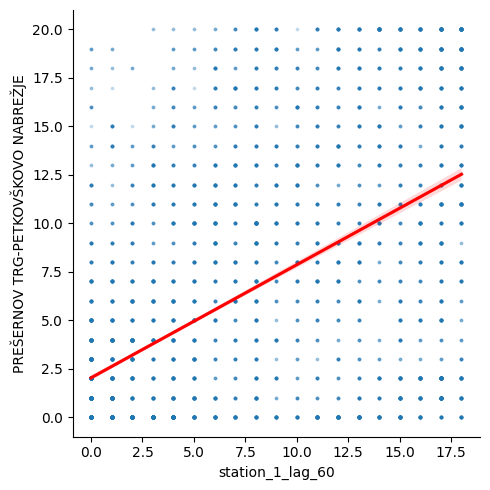

In [24]:
# Plot a regression plot to see the relationship between the target and the station_1_lag_60 feature for the first station
sns.lmplot(
    x="station_1_lag_60",
    y=df_list[0].columns[0],
    data=df_list[0],
    scatter_kws={"s": 3, "alpha": 0.2},
    line_kws={"color": "red"},
)
plt.show()

# Preprocessing (OneHotEncoding)

In [25]:
# OneHot encode the categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Define the categorical features
categoricals = ["hour", "dayofweek", "month"]
# Fit the encoder on the categorical features only
encoder.fit(df_list[0][categoricals])
def one_hot_encode(df, encoder=encoder, features=categoricals):
    df = df.copy()
    # Encode the categorical features
    encoded = pd.DataFrame(encoder.transform(df[features]))
    encoded.columns = encoder.get_feature_names_out(features)
    encoded.index = df.index
    # Concatenate the original dataframe and the encoded dataframe
    df = pd.concat([df, encoded], axis=1)
    # Drop the original categorical columns
    df = df.drop(features, axis=1)
    return df

In [26]:
# Use the one hot encoder on all dataframes
df_list = [one_hot_encode(station) for station in df_list]

display(df_list[0].tail())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,hour^6,hour^7,hour^8,...,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,month_8,month_9,month_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:03:00,18,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2022-10-01 18:07:00,20,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2022-10-01 18:13:00,19,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2022-10-01 18:16:00,19,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2022-10-01 18:23:00,20,274,1,0.847293,0.779921,0.717906,0.660822,0.608277,0.55991,0.515389,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Split the data into 60 min and 120 min lag

In [27]:
# # From the dataframes make two dataframes, one with all the features and 60 minutes lag and one with 120 minutes lag
df_list_60 = [station.drop(columns=["lag_120", "free_space_lag_120"]) for station in df_list]
for i in range(number_of_closest_stations):
    df_list_60 = [station.drop(columns=[f"station_{i+1}_lag_120"]) for station in df_list_60]
df_list_120 = [station.drop(columns=["lag_60", "free_space_lag_60"]) for station in df_list]
for i in range(number_of_closest_stations):
    df_list_120 = [station.drop(columns=[f"station_{i+1}_lag_60"]) for station in df_list_120]

# Model Testing With Cross Validation

In [28]:
def cross_validation_testing(df_list, params=None):
        tss = TimeSeriesSplit(n_splits=5, gap=(60 // 5))
        df_list = [station.sort_index() for station in df_list]
        scores_list = []
        preds_list = []
        for station in df_list:
                station.dropna(inplace=True)
                preds = []
                scores = []
                for train_idx, val_idx in tss.split(station):
                        train = station.iloc[train_idx]
                        test = station.iloc[val_idx]

                        FEATURES = train.columns[1:]
                        TARGET = station.columns[0]

                        X_train = train[FEATURES]
                        y_train = train[TARGET]

                        X_test = test[FEATURES]
                        y_test = test[TARGET]

                        model = LinearRegression()
                        
                        model.fit(X_train, y_train)

                        y_pred = model.predict(X_test)
                        preds.append(y_pred)
                        score = mean_absolute_error(y_test, y_pred)
                        # For some reason some of the scores were 1000000+ so I'm filtering them out
                        if score < 100: 
                                scores.append(score)
                
                preds_list.append(preds)
                scores_list.append(scores)

                print(f'{station.columns[0]}: Score across folds {np.mean(scores):0.4f}')
                # print(f'{station.columns[0]}: Fold scores:{scores}')
        return scores_list, preds_list

### Testing the 60 min lag models

In [29]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7739 entries, 2022-08-02 13:04:00 to 2022-10-01 18:23:00
Data columns (total 72 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE  7739 non-null   int64  
 1   dayofyear                           7739 non-null   int32  
 2   dayofmonth                          7739 non-null   int32  
 3   hour^2                              7739 non-null   float64
 4   hour^3                              7739 non-null   float64
 5   hour^4                              7739 non-null   float64
 6   hour^5                              7739 non-null   float64
 7   hour^6                              7739 non-null   float64
 8   hour^7                              7739 non-null   float64
 9   hour^8                              7739 non-null   float64
 10  hour^9                              7739 non-null   float64
 11  hour^10

In [30]:
scores_list_60, preds_list_60 = cross_validation_testing(df_list_60)
# print(f'Average Score: {np.mean(scores_list_60):0.4f}')

PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: Score across folds 2.9735
POGAČARJEV TRG-TRŽNICA: Score across folds 3.0915
KONGRESNI TRG-ŠUBIČEVA ULICA: Score across folds 2.6462
CANKARJEVA UL.-NAMA: Score across folds 4.0414
BREG: Score across folds 2.8782
GRUDNOVO NABREŽJE-KARLOVŠKA C.: Score across folds 1.9164
MIKLOŠIČEV PARK: Score across folds 2.5537
BAVARSKI DVOR: Score across folds 2.7074
TRG OF-KOLODVORSKA UL.: Score across folds 3.3463
MASARYKOVA DDC: Score across folds 2.5624
VILHARJEVA CESTA: Score across folds 2.2311
PARK NAVJE-ŽELEZNA CESTA: Score across folds 2.0845
TRG MDB: Score across folds 2.4332
PARKIRIŠČE NUK 2-FF: Score across folds 2.1906
AMBROŽEV TRG: Score across folds 3.4446
GH ŠENTPETER-NJEGOŠEVA C.: Score across folds 3.0854
ILIRSKA ULICA: Score across folds 2.4087
TRŽAŠKA C.-ILIRIJA: Score across folds 2.2973
TIVOLI: Score across folds 4.0706
STARA CERKEV: Score across folds 1.9359
KINO ŠIŠKA: Score across folds 3.5231
ŠPICA: Score across folds 2.3234
BARJANSKA C.-CEN

### Testing the 120 min lag models

In [31]:
scores_list_120, preds_list_120 = cross_validation_testing(df_list_120)
# print(f'Average Score: {np.mean(scores_list_120):0.4f}')

PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: Score across folds 4.1599
POGAČARJEV TRG-TRŽNICA: Score across folds 4.2782
KONGRESNI TRG-ŠUBIČEVA ULICA: Score across folds 3.9263
CANKARJEVA UL.-NAMA: Score across folds 5.2479
BREG: Score across folds 4.6990
GRUDNOVO NABREŽJE-KARLOVŠKA C.: Score across folds 3.0953
MIKLOŠIČEV PARK: Score across folds 3.1584
BAVARSKI DVOR: Score across folds 3.7759
TRG OF-KOLODVORSKA UL.: Score across folds 4.9623
MASARYKOVA DDC: Score across folds 3.9849
VILHARJEVA CESTA: Score across folds 3.3185
PARK NAVJE-ŽELEZNA CESTA: Score across folds 3.2729
TRG MDB: Score across folds 3.4254
PARKIRIŠČE NUK 2-FF: Score across folds 2.7603
AMBROŽEV TRG: Score across folds 4.6014
GH ŠENTPETER-NJEGOŠEVA C.: Score across folds 3.7988
ILIRSKA ULICA: Score across folds 3.1071
TRŽAŠKA C.-ILIRIJA: Score across folds 3.7755
TIVOLI: Score across folds 4.9591
STARA CERKEV: Score across folds 2.8040
KINO ŠIŠKA: Score across folds 5.2171
ŠPICA: Score across folds 4.7590
BARJANSKA C.-CEN

## Training the model on the whole dataset (One for each station)

In [32]:
def train_models(df_list):
    models = []
    for station in df_list:
        station.dropna(inplace=True)

        FEATURES = station.columns[1:]
        TARGET = station.columns[0]
        
        X_all = station[FEATURES]
        y_all = station[TARGET]
        
        reg = LinearRegression()
        reg.fit(X_all, y_all)
        
        models.append(reg)
    return models

In [33]:
models_60 = train_models(df_list_60)
models_120 = train_models(df_list_120)

## Preparing the test data for prediction

In [34]:
# Reading and preparing the test data
df_test = pd.read_csv("data/bicikelj_test.csv")
df_test = df_test.set_index("timestamp")
df_test.index = pd.to_datetime(df_test.index)
df_test = df_test.sort_index()

# Create a list of dataframes, one for each station for the test and train set
df_train_list = [df[[station]] for station in df.columns]
df_test_list = [df_test[[station]] for station in df_test.columns]

# Add the "Test" column to the dataframes
df_train_list = [station.assign(Test=False) for station in df_train_list]
df_test_list = [station.assign(Test=True) for station in df_test_list]

test_df_list = []
for train, test in zip(df_train_list, df_test_list):
        # Concatenate the two dataframes
        train_n_test = pd.concat([train, test], axis=0)
        train_n_test = train_n_test.sort_index()
        # Add the lags and datetime features
        train_n_test = create_features(train_n_test)
        train_n_test = add_poly_features(train_n_test, 'hour', 10)
        train_n_test = add_product_features(train_n_test, 'dayofweek')
        train_n_test = add_lags(train_n_test)
        train_n_test = add_school_days(train_n_test)
        train_n_test = add_weather(train_n_test, weather)
        train_n_test = free_spaces(train_n_test)
        train_n_test = add_n_closest(train_n_test, df_list, metadata, n=5)
        # One hot encode the categorical features
        train_n_test = one_hot_encode(train_n_test)
        # Select only the rows which are in the test set
        station_test = train_n_test[train_n_test["Test"] == True]
        # Drop the "Test" column
        station_test = station_test.drop("Test", axis=1)
        # Add the dataframe to the list
        test_df_list.append(station_test)

display(test_df_list[0].head())
display(test_df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,dayofyear,dayofmonth,hour^2,hour^3,hour^4,hour^5,hour^6,hour^7,hour^8,...,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,month_8,month_9,month_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-04 23:24:00,NaN,216,4,2.662666,4.344853,7.089791,11.568892,18.877746,30.804097,50.265133,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-08-05 00:24:00,NaN,217,5,2.690031,-4.412005,7.236268,-11.868432,19.465789,-31.926453,52.363580,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2022-08-08 04:58:00,NaN,220,8,1.147267,-1.228844,1.316222,-1.409812,1.510058,-1.617431,1.732440,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-08-08 05:58:00,NaN,220,8,0.862761,-0.801374,0.744356,-0.691394,0.642201,-0.596508,0.554065,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-08-11 21:13:00,NaN,223,11,1.815096,2.445396,3.294572,4.438628,5.979962,8.056533,10.854203,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    40
dayofyear                              0
dayofmonth                             0
hour^2                                 0
hour^3                                 0
                                      ..
dayofweek_5                            0
dayofweek_6                            0
month_8                                0
month_9                                0
month_10                               0
Length: 72, dtype: int64

In [35]:
# Make a list of dataframes from rows where lag_60 is not null
df_list_60 = [station[station["lag_60"].notnull()] for station in test_df_list]
# Remove the lag_120 columns 
df_list_60 = [station.drop("lag_120", axis=1) for station in df_list_60]
df_list_60 = [station.drop("free_space_lag_120", axis=1) for station in df_list_60]
for i in range(number_of_closest_stations):
    df_list_60 = [station.drop(f"station_{i+1}_lag_120", axis=1) for station in df_list_60]

# Make a list of dataframes from rows where lag_60 is null
df_list_120 = [station[station["lag_60"].isnull()] for station in test_df_list]
# Remove the lag_60 columns
df_list_120 = [station.drop("lag_60", axis=1) for station in df_list_120]
df_list_120 = [station.drop("free_space_lag_60", axis=1) for station in df_list_120]
for i in range(number_of_closest_stations):
    df_list_120 = [station.drop(f"station_{i+1}_lag_60", axis=1) for station in df_list_120]

## Predicting the test data

In [36]:
def make_predictions(models, df_list):
    preds_list = []
    for model, station in zip(models, df_list):
        # Get the predictions for the station
        pred = model.predict(station[station.columns[1:]])
        # Transform the predictions to integers
        # pred = pred.round(0).astype(np.int64)
        # Add the predictions to the list
        preds_list.append(pred)
    return preds_list

In [37]:
# Make the predictions
preds_list_60 = make_predictions(models_60, df_list_60)
preds_list_120 = make_predictions(models_120, df_list_120)

In [38]:
# Combine the predictions for 60 and 120 minutes into one list
preds_list_merged = []
for pred_60, pred_120 in zip(preds_list_60, preds_list_120):
    pred = []
    for i in range(len(pred_120)):
        pred.append(pred_60[i])
        pred.append(pred_120[i])
    preds_list_merged.append(pred)    

In [39]:
# Add the predictions to the test set
predicted = pd.read_csv("data/bicikelj_test.csv")
stations = predicted.columns[1:]
for station, pred in zip(stations, preds_list_merged):
        predicted[station] = pred

In [40]:
# Change every negative value to 0
for station in predicted.columns[1:]:
    predicted[station] = predicted[station].apply(lambda x: 0 if x < 0 else x)

# From each row of the metadata dataframe, get the "postaja" and the "total_space" and add them to a dictionary
capacity_dict = {}
for index, row in metadata.iterrows():
    capacity_dict[row["postaja"]] = row["total_space"]

# For each station check if the predicted number of bikes is greater than the capacity and if so, set it to the capacity
for station in predicted.columns[1:]:
    predicted[station] = predicted[station].apply(lambda x: capacity_dict[station] if x > capacity_dict[station] else x)

In [41]:
predicted.to_csv("data/predictions/predicted_LR_poly.csv", index=False)

In [42]:
# import pickle
# with open("models/models_LR_60.pkl", "wb") as f:
#     pickle.dump(models_60, f)

# with open("models/models_LR_120.pkl", "wb") as f:
#     pickle.dump(models_120, f)